In [465]:
from scipy.sparse import diags
import random
import numpy as np
import scipy as sc
import pandas as pd
import csv
import scipy.linalg as spl
import matplotlib.pyplot as plt
import time
import sys
sys.path.insert(0, '../../python/')
from opt_utils import *
from grad_utils import *
from ks_utils import *
from simulation_utils import *
from cv_utils import *
from scipy.special import logit


# Generate synethic data

### Helper functions

In [468]:
def sparse_matrix_list(T, N, betas, p_inner=0.5, p_outer=0.5):
    M = np.zeros((T, N, N))
    for t in range(T):
        # draw sparse random matches
        M[t] = np.random.binomial(1, p_inner, (N,N)) * np.tri(N, N, k=-1).T
        
        # randomly exclude certain competitors from competition
        n = np.random.binomial(N, p_outer)
        ineligible = np.random.choice(N, n, replace=False)
        for i in ineligible:
            M[t, i, :] = 0
            M[t, :, i] = 0
        sum1 = M[t, :, :].sum()
        # assign winner based on skill
        jstart = 1
        for i in range(N):
            for j in range(jstart, N):
                if M[t, i, j] == 1:
                    z = logit(np.random.uniform(0,1))
                    if z > betas[t, i] - betas[t, j]:
                        M[t, i, j] = 0
                        M[t, j, i] = 1
            jstart += 1
        sum2 = M[t, :, :].sum()
        assert sum1 == sum2
    return M

In [469]:
def convert_binary_array_to_triplets(array):
    triplets = []
    T, N, _ = array.shape
    
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if array[t, i, j] == 1:
                    triplets.append([t, i, j])
                    
    return np.array(triplets)
def triplets_to_TTT(array):
    M, _ = array.shape

    matches = []
    results = []
    dates = []

    for j in range(M):
        matches.append( [[array[j][1]], [array[j][2]]])
        results.append ( [1, 0])
        dates.append(array[j][0])
    return matches, results, dates


## making Plot

In [466]:
N = 50 # number of teams
T = 30 # number of seasons/rounds/years


In [489]:
[alpha,r] = [1.5,1.8]
##### get beta here #####
random.seed(0)
np.random.seed(0)
beta_gp = beta_gaussian_process(N, T, mu_parameters = [0,0.2], cov_parameters = [alpha,r], mu_type = 'constant', cov_type = 'toeplitz')
game_matrix_list = sparse_matrix_list(T, N, beta_gp, 1)
triplets = convert_binary_array_to_triplets(game_matrix_list)
matches, results, dates = triplets_to_TTT(triplets)
sparsity = 1- np.count_nonzero(game_matrix_list) / (T * N * (N-1)/2)
print('sparsity:', sparsity)

sparsity: 0.7209795918367348


c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


In [545]:
loc, scale = 0, 0.2
mu_start = stats.norm.rvs(loc = loc,scale = scale,size = N,random_state = 100)
mu = [np.ones(T) * mu_start[i] for i in range(N)]
##### strong auto-correlation case, off diagonal  = 1 - T^(-alpha) * |i - j|^r
off_diag = 1 - T ** (-alpha) * np.arange(1,T + 1) ** r
cov_single_path = sc.linalg.toeplitz(off_diag,off_diag)

np.random.multivariate_normal(mean = mu[0],cov = cov_single_path,size = 1).ravel().shape


C:\Users\austin\AppData\Local\Temp\ipykernel_11392\791252168.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  np.random.multivariate_normal(mean = mu[0],cov = cov_single_path,size = 1).ravel().shape


(30,)

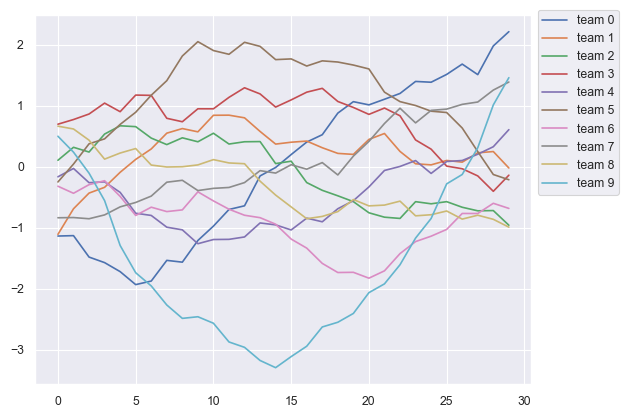

In [471]:
latent = beta_gp
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(latent[:,i], label="team %d"%i)
# plt.xlabel("season number")
# plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0))

In [472]:
data = game_matrix_list # shape: T*N*N
# true beta
beta_true = beta_gp + 0

### TTT

In [475]:
import trueskillthroughtime as ttt

sigs = np.linspace(0.05, 2, 10)
gams = np.linspace(0.01, 0.5, 10)
grid = np.zeros((len(sigs), len(gams)))
for i, sig in enumerate(sigs):
    for j, gam in enumerate(gams):
        h = ttt.History(composition=matches, results=results, times=dates, beta=1, mu=0, sigma=sig, gamma=gam)
        h.convergence(epsilon=.005)
        grid[i,j] = -h.log_evidence()

Iteration =  0 , step =  (0.2724415238558377, 0.007357745329511667)
Iteration =  1 

KeyboardInterrupt: 

In [481]:
index_of_min = np.unravel_index(grid.argmin(), grid.shape)
h = ttt.History(composition=matches, results=results, times=dates, beta=1, mu=0, sigma=sigs[index_of_min[0]], gamma=gams[index_of_min[1]])
h.convergence(epsilon=.005)
print(-h.log_evidence())
lc = h.learning_curves()

beta_ttt = np.zeros((T, N))
for i in lc.keys():
    for t, norm in lc[i]:
        beta_ttt[t, i] = norm.mu

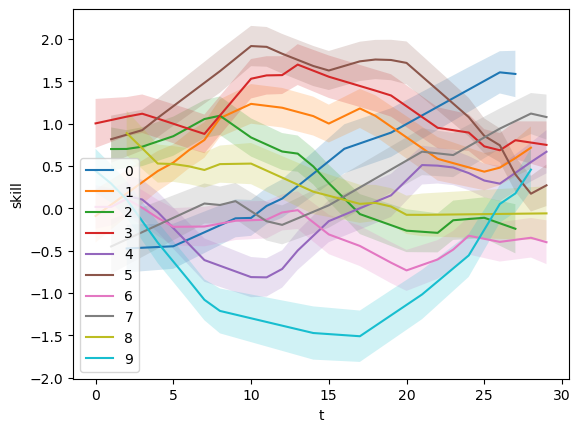

In [ ]:
pp = plt.figure(); plt.xlabel("t"); plt.ylabel("skill")
agents = h.agents.keys()
for i, agent in enumerate(agents):
    if i < 10:
        t = [v[0] for v in lc[agent]]
        mu = [v[1].mu for v in lc[agent]]
        sigma = [v[1].sigma for v in lc[agent]]
        plt.plot(t, mu, label=agent)
        plt.fill_between(t, [m+s for m,s in zip(mu, sigma)], [m-s for m,s in zip(mu, sigma)], alpha=0.2)

plt.legend()
plt.show()

In [ ]:
T, N = data.shape[0:2]
ks_data = kernel_smooth(data,1/6 * T**(-1/5))
objective_pgd, beta_pgd = gd_bt(data = ks_data,verbose=True)

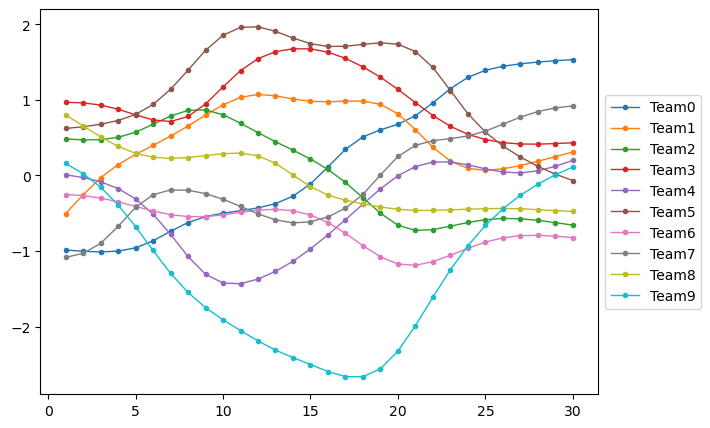

In [ ]:
T, N = data.shape[0:2]
beta = beta_pgd.reshape((T,N))
f = plt.figure(1, figsize = (9,5))
ax = plt.subplot(111)
for i in range(10):
    ax.plot(range(1,T + 1),beta[:,i],marker = '.',label = 'Team' + str(i),linewidth=1)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
# f.savefig("l2_sq_solution.pdf", bbox_inches='tight')

### LOOCV

In [ ]:
start_time = time.time()

random.seed(0)
np.random.seed(0)
h_list = np.linspace(0.45, 0.01, 5)
# h_cv, nll_cv, beta_cv, prob_cv = cv_utils.loocv_ks(data, h_list, gd_bt, num_loocv = 200, return_prob = True, out = "notebook")
h_cv, nll_cv, beta_cv, prob_cv = loocv_ks(data, h_list, gd_bt, num_loocv = 100, return_prob = True, out = "notebook")
loo_nll_DBT, loo_prob_DBT = max(nll_cv), prob_cv[np.argmax(nll_cv)]

print("--- %s seconds ---" % (time.time() - start_time))

1-th cv done
2-th cv done
3-th cv done
4-th cv done
5-th cv done
6-th cv done
7-th cv done
8-th cv done
9-th cv done
10-th cv done
11-th cv done
12-th cv done
13-th cv done
14-th cv done
15-th cv done
16-th cv done
17-th cv done
18-th cv done
19-th cv done
20-th cv done
21-th cv done
22-th cv done
23-th cv done
24-th cv done
25-th cv done
26-th cv done
27-th cv done
28-th cv done
29-th cv done
30-th cv done
31-th cv done
32-th cv done
33-th cv done
34-th cv done
35-th cv done
36-th cv done
37-th cv done
38-th cv done
39-th cv done
40-th cv done
41-th cv done
42-th cv done
43-th cv done
44-th cv done
45-th cv done
46-th cv done
47-th cv done
48-th cv done
49-th cv done
50-th cv done
51-th cv done
52-th cv done
53-th cv done
54-th cv done
55-th cv done
56-th cv done
57-th cv done
58-th cv done
59-th cv done
60-th cv done
61-th cv done
62-th cv done
63-th cv done
64-th cv done
65-th cv done
66-th cv done
67-th cv done
68-th cv done
69-th cv done
70-th cv done
71-th cv done
72-th cv done
7

In [ ]:
h_cv

0.12

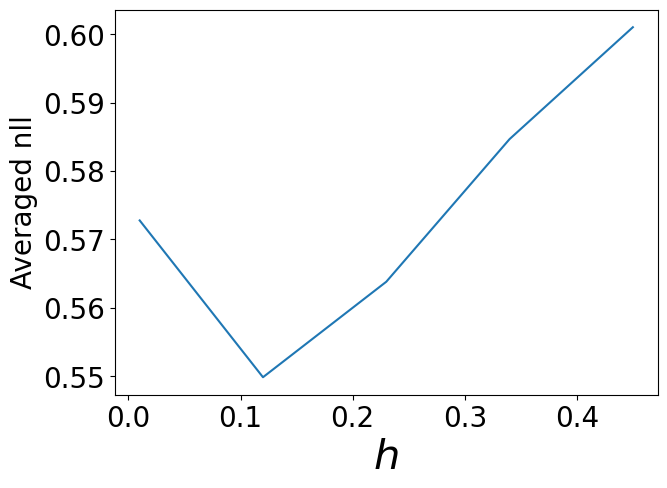

In [ ]:
f = plt.figure(1, figsize = (7,5))
size_ylabel = 20
size_xlabel = 30
size_tick = 20

nll_cv = nll_cv
plt.plot(h_list[::-1], nll_cv)
plt.xlabel(r'$h$',fontsize = size_xlabel); plt.ylabel(r"Averaged nll",fontsize = size_ylabel)
plt.tick_params(axis='both', which='major', labelsize=size_tick)

# f.savefig("cv_curve.pdf", bbox_inches='tight')

In [ ]:
# import time
# start_time = time.time()

# random.seed(0)
# np.random.seed(0)
# h = 0.1
# nll_DBT, beta_DBT, prob_DBT = loo_DBT(data, h, gd_bt, num_loo = 200, return_prob = True, out = "notebook")

# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# winrate
random.seed(0)
np.random.seed(0)
winrate = get_winrate(data)
loo_nll_wr, loo_prob_wr = loo_winrate(data)

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


In [ ]:
loo_prob_wr

0.4236701421455831

In [ ]:
# vanilla BT
import time
start_time = time.time()

random.seed(0)
np.random.seed(0)
objective_vanilla_bt, beta_vanilla_bt = gd_bt(data = data,verbose = True)
loo_nll_vBT, loo_prob_vBT = loo_vBT(data,num_loo = 200)

print("--- %s seconds ---" % (time.time() - start_time))

initial objective value: 7107.531189
1-th GD, objective value: 5341.832524
2-th GD, objective value: 5071.756604
3-th GD, objective value: 5044.364603
4-th GD, objective value: 5043.297548
5-th GD, objective value: 5042.745965
6-th GD, objective value: 5042.605473
7-th GD, objective value: 5042.541453
8-th GD, objective value: 5042.483059
9-th GD, objective value: 5042.462771
10-th GD, objective value: 5042.451506
11-th GD, objective value: 5042.440666
12-th GD, objective value: 5042.436871
13-th GD, objective value: 5042.432146
14-th GD, objective value: 5042.430377
15-th GD, objective value: 5042.429240
16-th GD, objective value: 5042.427954
17-th GD, objective value: 5042.427416
18-th GD, objective value: 5042.427068
19-th GD, objective value: 5042.426694
20-th GD, objective value: 5042.426555
21-th GD, objective value: 5042.426359
22-th GD, objective value: 5042.426286
23-th GD, objective value: 5042.426216
24-th GD, objective value: 5042.426180
25-th GD, objective value: 5042.4261

In [ ]:
def rel_av_dif_rank(triplets, beta_true, beta_i):
    result = [0] * T
    for t in np.unique(triplets[:,0]):
        to_check = np.unique(triplets[triplets[:, 0] == t][:, 1:3])
        r_beta_i = beta_i[t, to_check]
        r_beta_true = beta_true[t, to_check]

        rank1t = rank_list(r_beta_i)
        rank2t = rank_list(r_beta_true)
        result[t] = np.mean(abs(rank1t - rank2t))
    return result


In [ ]:
beta_ttt

array([[ 0.        , -0.08957035,  0.        , ...,  0.        ,
         0.        , -0.19450808],
       [ 0.        ,  0.        ,  0.70012872, ..., -0.19623054,
         0.        ,  0.        ],
       [-0.47335612,  0.        ,  0.70098568, ...,  0.        ,
         0.02022175,  0.        ],
       ...,
       [ 1.58621725,  0.59316858, -0.24081419, ...,  0.        ,
        -0.08244992,  1.15064293],
       [ 0.        ,  0.71610126,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.38220452,
         0.        ,  0.        ]])

In [503]:
rank_dif_estimator = [0] * 4
beta_all = [winrate,beta_vanilla_bt,beta_cv, beta_ttt]
for i in range(len(rank_dif_estimator)):
    betai = beta_all[i]
    rank_dif_estimator[i] = np.mean(rel_av_dif_rank(triplets, beta_true,betai))
rank_dif_estimator


In [ ]:

df = pd.DataFrame({'estimator':['winrate','naive BT','DBT', 'TTT'],f'{sparsity:.2f} ard':rank_dif_estimator,
                  })

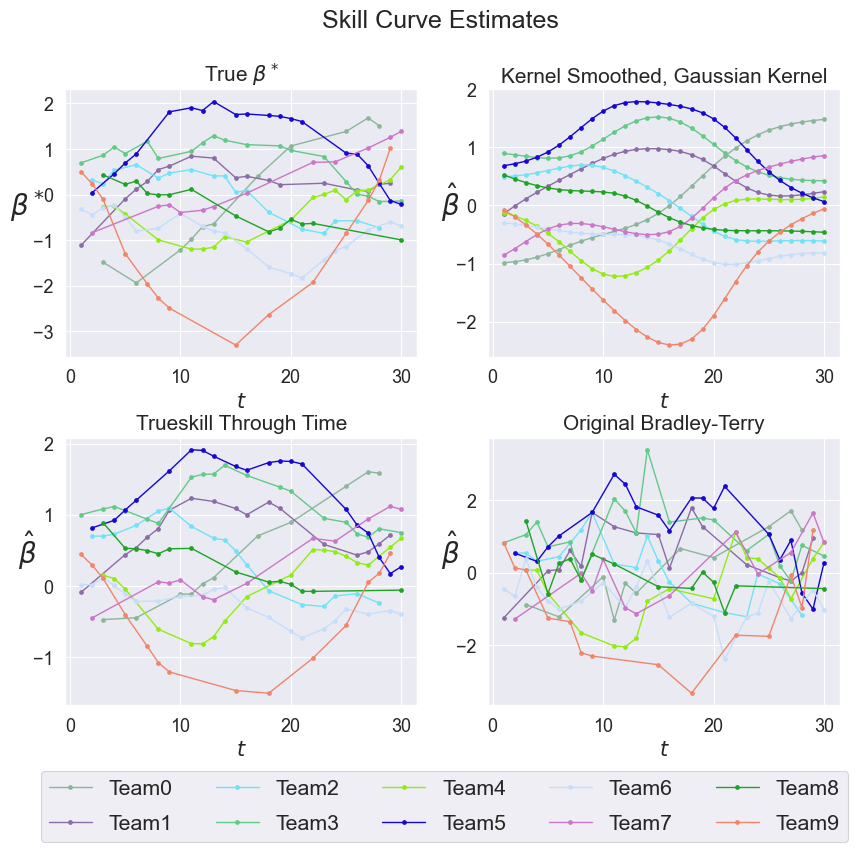

In [476]:
import seaborn as sns
sns.set_theme('paper')
T, N = data.shape[0:2]
f = plt.figure(1, figsize = (10,8), )

size_ylabel = 20
size_xlabel = 15
size_title = 15
size_tick = 13
size_legend = 15.4
font_title = "Times New Roman Bold"

random.seed(0)
np.random.seed(0)
color_matrix = c=np.random.rand(N,3)


beta = beta_cv.reshape((T,N))
ax = plt.subplot(222)
for i in range(10):
    ax.plot(range(1,T + 1),beta[:,i],c=color_matrix[i,:],marker = '.',label = 'Team' + str(i),linewidth=1)
    ax.tick_params(axis='both', which='major', labelsize=size_tick)
    plt.title(r"Kernel Smoothed, Gaussian Kernel",fontsize = size_title)
    plt.xlabel(r"$t$",fontsize = size_xlabel); plt.ylabel(r"$\hat{\beta}$",fontsize = size_ylabel,rotation = "horizontal")
    bottom, top = plt.ylim()

#     plt.ylim((bottom, top))


beta_t = beta_ttt.reshape((T,N))
beta = beta_t
ax = plt.subplot(223)
for i in range(10):
    x = np.arange(1, T+1)
    betas = beta[:,i]
    ax.plot(x[betas != 0],betas[betas != 0],c=color_matrix[i,:],marker = '.',label = 'Team' + str(i),linewidth=1)
    ax.tick_params(axis='both', which='major', labelsize=size_tick)
    plt.title(r"Trueskill Through Time",fontsize = size_title)
    plt.xlabel(r"$t$",fontsize = size_xlabel); plt.ylabel(r"$\hat{\beta}$",fontsize = size_ylabel,rotation = "horizontal")


ax.legend(loc='lower left', fontsize = size_legend,labelspacing = 0.75,bbox_to_anchor=(-0.1,-0.55),ncol = 5)


beta = beta_vanilla_bt.reshape((T,N))
ax = plt.subplot(224)
for i in range(10):
    x = np.arange(1, T+1)
    betas = beta[:,i]
    ax.plot(x[betas != 0],betas[betas != 0],c=color_matrix[i,:],marker = '.',label = 'Team' + str(i),linewidth=1)
    ax.tick_params(axis='both', which='major', labelsize=size_tick)
    plt.title(r"Original Bradley-Terry",fontsize = size_title)
    plt.xlabel(r"$t$",fontsize = size_xlabel); plt.ylabel(r"$\hat{\beta}$",fontsize = size_ylabel,rotation = "horizontal")
    
beta = beta_true.reshape((T,N))
ax = plt.subplot(221)
for i in range(10):
    x = np.arange(1, T+1)
    betas = beta[:,i]
    ax.plot(x[beta_t[:, i] != 0],betas[beta_t[:, i] != 0],c=color_matrix[i,:],marker = '.',label = 'Team' + str(i),linewidth=1)
    ax.tick_params(axis='both', which='major', labelsize=size_tick)
    plt.title(r"True $\beta^*$",fontsize = size_title)
    plt.xlabel(r"$t$",fontsize = size_xlabel); plt.ylabel(r"${\beta}^*$",fontsize = size_ylabel,rotation = "horizontal")
    
plt.suptitle('Skill Curve Estimates', fontsize = size_title+3)
plt.subplots_adjust(hspace = 0.3)
plt.show()
# f.savefig("compare.pdf", bbox_inches='tight')

## bradley-terry experiments

In [ ]:
df_bt = pd.DataFrame()

In [510]:
for s1, inner_ps in enumerate([1, 0.75, 0.5]):
    for s2, outer_ps in enumerate([0, 0.25, 0.5]):
        N = 50 # number of teams
        T = 30 # number of seasons/rounds/years

        [alpha,r] = [1.5,1.8]
        ##### get beta here #####
        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        beta_gp = beta_gaussian_process(N, T, mu_parameters = [0,0.2], cov_parameters = [alpha,r], mu_type = 'constant', cov_type = 'toeplitz')
        tn = [1] * int(T * N * (N - 1)/2) # number of games between each pair of teams
        game_matrix_list = get_game_matrix_list(N, T, tn, beta_gp)

        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        for t in range(T):
            n = np.random.binomial(N, outer_ps)
            ineligible = np.random.choice(N, n, replace=False)
            for i in ineligible:
                game_matrix_list[t, i, :] = 0
                game_matrix_list[t, :, i] = 0
            dropouts = np.random.binomial(1, inner_ps, (N, N))
            game_matrix_list[t,:,:] *= dropouts

        triplets = convert_binary_array_to_triplets(game_matrix_list)
        matches, results, dates = triplets_to_TTT(triplets)
        sparsity = 1- np.count_nonzero(game_matrix_list) / (T * N * (N-1)/2)
        print('sparsity:', sparsity)

        data = game_matrix_list # shape: T*N*N
        # true beta
        beta_true = beta_gp + 0

        sigs = np.linspace(0.05, 2, 10)
        gams = np.linspace(0.01, 0.5, 10)
        grid = np.zeros((len(sigs), len(gams)))
        for i, sig in enumerate(sigs):
            for j, gam in enumerate(gams):
                h = ttt.History(composition=matches, results=results, times=dates, beta=1, mu=0, sigma=sig, gamma=gam)
                h.convergence(epsilon=.005, iterations=12)
                grid[i,j] = -h.log_evidence()

        index_of_min = np.unravel_index(grid.argmin(), grid.shape)
        h = ttt.History(composition=matches, results=results, times=dates, beta=1, mu=0, sigma=sigs[index_of_min[0]], gamma=gams[index_of_min[1]])
        h.convergence(epsilon=.005, iterations=35)
        lc = h.learning_curves()

        beta_ttt = np.zeros((T, N))
        for i in lc.keys():
            for t, norm in lc[i]:
                beta_ttt[t, i] = norm.mu


        T, N = data.shape[0:2]
        ks_data = kernel_smooth(data,1/6 * T**(-1/5))
        objective_pgd, beta_pgd = gd_bt(data = ks_data,verbose=True)

        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        h_list = np.linspace(0.45, 0.01, 10)
        # h_cv, nll_cv, beta_cv, prob_cv = cv_utils.loocv_ks(data, h_list, gd_bt, num_loocv = 200, return_prob = True, out = "notebook")
        h_cv, nll_cv, beta_cv, prob_cv = loocv_ks(data, h_list, gd_bt, num_loocv = 100, return_prob = True, out = "notebook")
        loo_nll_DBT, loo_prob_DBT = max(nll_cv), prob_cv[np.argmax(nll_cv)]

        # winrate
        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        winrate = get_winrate(data)
        loo_nll_wr, loo_prob_wr = loo_winrate(data)

        random.seed(0)
        np.random.seed(0)
        objective_vanilla_bt, beta_vanilla_bt = gd_bt(data = data,verbose = True)
        loo_nll_vBT, loo_prob_vBT = loo_vBT(data,num_loo = 200)

        rank_dif_estimator = [0] * 4
        beta_all = [winrate,beta_vanilla_bt,beta_cv, beta_ttt]
        for i in range(len(rank_dif_estimator)):
            betai = beta_all[i]
            rank_dif_estimator[i] = np.mean(rel_av_dif_rank(triplets, beta_true,betai))

        df_bt[f'{sparsity} ard'] = rank_dif_estimator

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.0
Iteration =  0 , step =  (0.45871047022421985, 0.01196404641903795)
Iteration =  1 , step =  (0.0005049157733029164, 5.326087518423006e-06)
End
Iteration =  0 , step =  (0.7759243523558235, 0.04175163886765268)
Iteration =  1 , step =  (0.013859217799116162, 0.0003523665886268207)
Iteration =  2 , step =  (0.00044898738835398577, 1.8221617634248122e-05)
End
Iteration =  0 , step =  (0.6684902762891867, 0.056524168329298324)
Iteration =  1 , step =  (0.03165584365342233, 0.0008686684601222627)
Iteration =  2 , step =  (0.0022256726457219322, 9.020184099298167e-05)
End
Iteration =  0 , step =  (0.5772766146612782, 0.06569735904623417)
Iteration =  1 , step =  (0.048990878191382925, 0.00124431143902759)
Iteration =  2 , step =  (0.004288322713826176, 0.00019838367445262906)
End
Iteration =  0 , step =  (0.5171770819061641, 0.07134282967990332)
Iteration =  1 , step =  (0.06428520556520667, 0.001372904742258596)
Iteration =  2 , step =  (0.006554521496289434, 0.00032601044646

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.4292517006802721
Iteration =  0 , step =  (0.397790759556096, 0.010747516328976761)
Iteration =  1 , step =  (0.000593501266860752, 8.638711375928698e-06)
End
Iteration =  0 , step =  (0.7647352740458064, 0.05836866906174849)
Iteration =  1 , step =  (0.01434847138312545, 0.0005886331702518732)
Iteration =  2 , step =  (0.001094508727488952, 4.6373770179436447e-05)
End
Iteration =  0 , step =  (0.7035194541698894, 0.09948963816000542)
Iteration =  1 , step =  (0.0353600213427927, 0.0014657771871748604)
Iteration =  2 , step =  (0.003112474161169443, 0.00020717461372996016)
End
Iteration =  0 , step =  (0.7370829720941059, 0.11888292142155829)
Iteration =  1 , step =  (0.0570497092087795, 0.0021127278878781686)
Iteration =  2 , step =  (0.006466877994911746, 0.0004094876065734998)
Iteration =  3 , step =  (0.0017181423788896755, 4.8898178009598725e-05)
End
Iteration =  0 , step =  (0.7841826459250549, 0.1245929244774828)
Iteration =  1 , step =  (0.07713549455643354, 0.00273

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


14-th GD, objective value: 10265.904909
15-th GD, objective value: 10265.853976
16-th GD, objective value: 10265.809716
17-th GD, objective value: 10265.770820
18-th GD, objective value: 10265.740674
19-th GD, objective value: 10265.669622
20-th GD, objective value: 10265.622171
21-th GD, objective value: 10265.593394
22-th GD, objective value: 10265.543945
23-th GD, objective value: 10265.522092
24-th GD, objective value: 10265.502061
25-th GD, objective value: 10265.487867
26-th GD, objective value: 10265.449940
27-th GD, objective value: 10265.421540
28-th GD, objective value: 10265.407416
29-th GD, objective value: 10265.378286
30-th GD, objective value: 10265.360582
31-th GD, objective value: 10265.344248
32-th GD, objective value: 10265.321501
33-th GD, objective value: 10265.311073
34-th GD, objective value: 10265.303721
35-th GD, objective value: 10265.283406
36-th GD, objective value: 10265.267527
37-th GD, objective value: 10265.259796
38-th GD, objective value: 10265.243068


c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.7478095238095238
Iteration =  0 , step =  (0.3154480227564741, 0.007277537231317313)
Iteration =  1 , step =  (0.00042797495131891017, 5.7517986597199755e-06)
End
Iteration =  0 , step =  (0.713144624923095, 0.071947286556408)
Iteration =  1 , step =  (0.00913614287166524, 0.0006968346699366412)
Iteration =  2 , step =  (0.00217353831852074, 1.740842277708765e-05)
End
Iteration =  0 , step =  (0.8139183310307158, 0.11598254095259308)
Iteration =  1 , step =  (0.028307953904135208, 0.0018917157230730897)
Iteration =  2 , step =  (0.001752595944985752, 8.421484719112193e-05)
End
Iteration =  0 , step =  (0.9053385233082434, 0.130770586093812)
Iteration =  1 , step =  (0.05009929171511607, 0.002849942108921366)
Iteration =  2 , step =  (0.004214299108182884, 0.0001972983650000426)
End
Iteration =  0 , step =  (0.9286943049340424, 0.14702397849436527)
Iteration =  1 , step =  (0.07094980813498153, 0.003397257984031732)
Iteration =  2 , step =  (0.007554241612129864, 0.000320859

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


19-th GD, objective value: 4311.391283
20-th GD, objective value: 4311.320786
21-th GD, objective value: 4311.267188
22-th GD, objective value: 4311.212342
23-th GD, objective value: 4311.166498
24-th GD, objective value: 4311.133665
25-th GD, objective value: 4311.083299
26-th GD, objective value: 4311.055085
27-th GD, objective value: 4311.013449
28-th GD, objective value: 4310.988673
29-th GD, objective value: 4310.954047
30-th GD, objective value: 4310.931830
31-th GD, objective value: 4310.902987
32-th GD, objective value: 4310.882646
33-th GD, objective value: 4310.858705
34-th GD, objective value: 4310.839690
35-th GD, objective value: 4310.820026
36-th GD, objective value: 4310.806099
37-th GD, objective value: 4310.784082
38-th GD, objective value: 4310.771646
39-th GD, objective value: 4310.752366
40-th GD, objective value: 4310.740873
41-th GD, objective value: 4310.723986
42-th GD, objective value: 4310.713224
43-th GD, objective value: 4310.698470
44-th GD, objective value

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.248843537414966
Iteration =  0 , step =  (0.4308724413956885, 0.010660180348368409)
Iteration =  1 , step =  (0.0003345602554633287, 7.260964349387056e-06)
End
Iteration =  0 , step =  (1.014026956746892, 0.044723964513611464)
Iteration =  1 , step =  (0.009055943627500562, 0.0004793101587251547)
Iteration =  2 , step =  (0.0009741248095692656, 1.9495920704770686e-05)
End
Iteration =  0 , step =  (0.8796397602131738, 0.0597166047875943)
Iteration =  1 , step =  (0.022984591201826388, 0.0013412859424730694)
Iteration =  2 , step =  (0.0020781190466602206, 0.00011313007767674299)
End
Iteration =  0 , step =  (0.7204477196784365, 0.0656579675793387)
Iteration =  1 , step =  (0.035654394121470756, 0.0022235189782089937)
Iteration =  2 , step =  (0.003164966787585932, 0.0002830267415678822)
End
Iteration =  0 , step =  (0.6113643306634158, 0.07119881021400451)
Iteration =  1 , step =  (0.04801320165931089, 0.002969395657084206)
Iteration =  2 , step =  (0.0044446060871421444, 0.

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.5670204081632653
Iteration =  0 , step =  (0.3945374713151817, 0.009117807429770114)
Iteration =  1 , step =  (0.00041336098762969915, 5.536795145068274e-06)
End
Iteration =  0 , step =  (0.6837829379873909, 0.05346434344455858)
Iteration =  1 , step =  (0.010603408956458837, 0.00047974010062923345)
Iteration =  2 , step =  (0.00313711952933083, 3.402108316605257e-05)
End
Iteration =  0 , step =  (0.6708548643613728, 0.07639405836351662)
Iteration =  1 , step =  (0.025262871724383157, 0.0010423413147729876)
Iteration =  2 , step =  (0.004370266474968493, 0.00019300076377778974)
End
Iteration =  0 , step =  (0.6335985967799067, 0.09407035457117102)
Iteration =  1 , step =  (0.04272247159306962, 0.0017434254810456407)
Iteration =  2 , step =  (0.005745480902014988, 0.00046753379974628917)
Iteration =  3 , step =  (0.004453895321186702, 4.6361543638462344e-05)
End
Iteration =  0 , step =  (0.6112021073820499, 0.1109643177750681)
Iteration =  1 , step =  (0.05984566968089596, 0

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


17-th GD, objective value: 7682.967626
18-th GD, objective value: 7682.918334
19-th GD, objective value: 7682.828857
20-th GD, objective value: 7682.765846
21-th GD, objective value: 7682.731877
22-th GD, objective value: 7682.670362
23-th GD, objective value: 7682.626098
24-th GD, objective value: 7682.600972
25-th GD, objective value: 7682.555998
26-th GD, objective value: 7682.523271
27-th GD, objective value: 7682.503747
28-th GD, objective value: 7682.469416
29-th GD, objective value: 7682.444327
30-th GD, objective value: 7682.428585
31-th GD, objective value: 7682.401527
32-th GD, objective value: 7682.381770
33-th GD, objective value: 7682.368708
34-th GD, objective value: 7682.346847
35-th GD, objective value: 7682.330961
36-th GD, objective value: 7682.319871
37-th GD, objective value: 7682.301856
38-th GD, objective value: 7682.288868
39-th GD, objective value: 7682.279276
40-th GD, objective value: 7682.264187
41-th GD, objective value: 7682.256010
42-th GD, objective value

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.8146122448979591
Iteration =  0 , step =  (0.18214174682563888, 0.006162657177551226)
Iteration =  1 , step =  (0.00010456265392659592, 3.4506458110178384e-06)
End
Iteration =  0 , step =  (0.6213668586885173, 0.059973572782264756)
Iteration =  1 , step =  (0.00696699053838689, 0.00042216218324436783)
Iteration =  2 , step =  (0.0004723188424601288, 2.5886572202232783e-05)
End
Iteration =  0 , step =  (0.68073221134586, 0.09578149182121332)
Iteration =  1 , step =  (0.01873476272604177, 0.0015611574553148766)
Iteration =  2 , step =  (0.0017663159186051547, 0.00014825212367108875)
End
Iteration =  0 , step =  (0.6986233643323302, 0.12241330683060539)
Iteration =  1 , step =  (0.031468076820769075, 0.003261606645675874)
Iteration =  2 , step =  (0.003367591898247868, 0.00034646806386046114)
End
Iteration =  0 , step =  (0.7410551258746231, 0.14193351451595043)
Iteration =  1 , step =  (0.04348202072870966, 0.004850516972648822)
Iteration =  2 , step =  (0.004709502502405205,

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


18-th GD, objective value: 3195.377901
19-th GD, objective value: 3195.297696
20-th GD, objective value: 3195.237160
21-th GD, objective value: 3195.163116
22-th GD, objective value: 3195.101028
23-th GD, objective value: 3195.061099
24-th GD, objective value: 3195.004529
25-th GD, objective value: 3194.955156
26-th GD, objective value: 3194.914528
27-th GD, objective value: 3194.882491
28-th GD, objective value: 3194.842575
29-th GD, objective value: 3194.807900
30-th GD, objective value: 3194.785567
31-th GD, objective value: 3194.752797
32-th GD, objective value: 3194.723447
33-th GD, objective value: 3194.698548
34-th GD, objective value: 3194.679321
35-th GD, objective value: 3194.654360
36-th GD, objective value: 3194.632229
37-th GD, objective value: 3194.617997
38-th GD, objective value: 3194.596614
39-th GD, objective value: 3194.577113
40-th GD, objective value: 3194.560190
41-th GD, objective value: 3194.547553
42-th GD, objective value: 3194.530429
43-th GD, objective value

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.4998095238095238
Iteration =  0 , step =  (0.3926591503573804, 0.008878582207071072)
Iteration =  1 , step =  (0.00017877496563387107, 4.267706585521502e-06)
End
Iteration =  0 , step =  (0.7701991988650364, 0.04916774842298316)
Iteration =  1 , step =  (0.005252640095418357, 0.00030649651130237876)
Iteration =  2 , step =  (0.00028785943660813995, 1.3884246392925625e-05)
End
Iteration =  0 , step =  (0.7336496464928659, 0.07387650198361223)
Iteration =  1 , step =  (0.016016314994839964, 0.0009617581316047064)
Iteration =  2 , step =  (0.0010797280846429613, 8.466164480477878e-05)
End
Iteration =  0 , step =  (0.6376405137161645, 0.08899441267531816)
Iteration =  1 , step =  (0.029046069735187835, 0.0017004621204672332)
Iteration =  2 , step =  (0.0020296008446765157, 0.00023593111581388104)
End
Iteration =  0 , step =  (0.5813247633094573, 0.10184729452511715)
Iteration =  1 , step =  (0.04260631400714002, 0.0023403532328858945)
Iteration =  2 , step =  (0.003440639532277

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.7037551020408164
Iteration =  0 , step =  (0.316793838415534, 0.0075438692480689)
Iteration =  1 , step =  (0.00024636123066934523, 5.6046301772014195e-06)
End
Iteration =  0 , step =  (0.7954895985387358, 0.062419128523846124)
Iteration =  1 , step =  (0.007887067898906697, 0.00048536268676782623)
Iteration =  2 , step =  (0.0005404376054360949, 3.176425626061352e-05)
End
Iteration =  0 , step =  (0.8261616875963866, 0.09510028256477421)
Iteration =  1 , step =  (0.022138591575904004, 0.0014774806821525877)
Iteration =  2 , step =  (0.0016925658780029829, 0.0001810643306737192)
End
Iteration =  0 , step =  (0.8214958856480854, 0.1193865127361999)
Iteration =  1 , step =  (0.03955281380755998, 0.0026276897744442473)
Iteration =  2 , step =  (0.003327151856599486, 0.0004626197636239393)
End
Iteration =  0 , step =  (0.9208322412145071, 0.1363314746118729)
Iteration =  1 , step =  (0.05672332030201882, 0.003938603098636861)
Iteration =  2 , step =  (0.005331028063797836, 0.00

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


17-th GD, objective value: 4901.343933
18-th GD, objective value: 4901.194167
19-th GD, objective value: 4901.027111
20-th GD, objective value: 4900.916845
21-th GD, objective value: 4900.776931
22-th GD, objective value: 4900.691974
23-th GD, objective value: 4900.573359
24-th GD, objective value: 4900.505629
25-th GD, objective value: 4900.403953
26-th GD, objective value: 4900.327414
27-th GD, objective value: 4900.260425
28-th GD, objective value: 4900.190318
29-th GD, objective value: 4900.137189
30-th GD, objective value: 4900.073410
31-th GD, objective value: 4900.030116
32-th GD, objective value: 4899.972247
33-th GD, objective value: 4899.936153
34-th GD, objective value: 4899.883666
35-th GD, objective value: 4899.852986
36-th GD, objective value: 4899.805333
37-th GD, objective value: 4899.767787
38-th GD, objective value: 4899.735480
39-th GD, objective value: 4899.699628
40-th GD, objective value: 4899.672742
41-th GD, objective value: 4899.638878
42-th GD, objective value

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:47: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.8881088435374149
Iteration =  0 , step =  (0.1268688973517052, 0.004008337760515894)
Iteration =  1 , step =  (0.00010798299715084406, 3.978076581367951e-06)
End
Iteration =  0 , step =  (0.6792803906175584, 0.058195442487827126)
Iteration =  1 , step =  (0.0062668046154436, 0.0007630310315993039)
Iteration =  2 , step =  (0.0003220137560024372, 1.964805007589887e-05)
End
Iteration =  0 , step =  (0.9849699674816731, 0.1285209422048011)
Iteration =  1 , step =  (0.015900241715295138, 0.0024929467962026552)
Iteration =  2 , step =  (0.002119942465256555, 0.00014263703340267053)
End
Iteration =  0 , step =  (1.0102827913676409, 0.1968011491502067)
Iteration =  1 , step =  (0.029667349414435717, 0.00428622380630217)
Iteration =  2 , step =  (0.0049431161951759076, 0.0003713681909440769)
End
Iteration =  0 , step =  (0.9458243384098548, 0.2613627407776715)
Iteration =  1 , step =  (0.044097573149615155, 0.005523629127376972)
Iteration =  2 , step =  (0.007515314162931396, 0.000

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


21-th GD, objective value: 1731.718534
22-th GD, objective value: 1731.526279
23-th GD, objective value: 1731.352095
24-th GD, objective value: 1731.193518
25-th GD, objective value: 1731.048626
26-th GD, objective value: 1730.915715
27-th GD, objective value: 1730.793414
28-th GD, objective value: 1730.680507
29-th GD, objective value: 1730.575990
30-th GD, objective value: 1730.478972
31-th GD, objective value: 1730.388701
32-th GD, objective value: 1730.304509
33-th GD, objective value: 1730.225822
34-th GD, objective value: 1730.152127
35-th GD, objective value: 1730.082980
36-th GD, objective value: 1730.017982
37-th GD, objective value: 1729.956783
38-th GD, objective value: 1729.899067
39-th GD, objective value: 1729.844554
40-th GD, objective value: 1729.792993
41-th GD, objective value: 1729.744157
42-th GD, objective value: 1729.697842
43-th GD, objective value: 1729.653863
44-th GD, objective value: 1729.612053
45-th GD, objective value: 1729.572261
46-th GD, objective value

In [511]:
df

,estimator,0.72 ard,0.0 ard,0.4292517006802721 ard,0.7478095238095238 ard,0.248843537414966 ard,0.5670204081632653 ard,0.8146122448979591 ard,0.4998095238095238 ard,0.7037551020408164 ard,0.8881088435374149 ard
0,winrate,2.539432,3.552000,2.871427,2.392471,4.420000,3.535745,2.932628,4.876000,4.113588,3.264831
1,naive BT,2.534580,3.525333,2.896071,2.348713,4.348000,3.403311,2.877365,4.810667,4.039561,3.323073
2,DBT,1.802419,2.570667,2.860069,2.001295,2.552000,2.065212,2.093479,4.773333,2.229102,1.974085
3,TTT,1.630952,2.040000,1.713350,1.507429,2.353333,1.950994,1.628388,2.490667,2.153042,1.950551


## model agnostic 

In [553]:
df_ma = pd.DataFrame()

In [554]:
for s1, inner_ps in enumerate([1, 0.75, 0.5]):
    for s2, outer_ps in enumerate([0, 0.25, 0.5]):
        N = 50 # number of teams
        T = 30 # number of seasons/rounds/years

        [alpha,r] = [1.5,1.8]
        ##### get beta here #####
        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        P_list = make_prob_matrix(T,N,r = r,alpha = alpha,mu = [0,0.2])
        tn = [1] * int(T * N * (N - 1)/2) # number of games between each pair of teams
        game_matrix_list = get_game_matrix_list_from_P(tn,P_list)

        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        for t in range(T):
            n = np.random.binomial(N, outer_ps)
            ineligible = np.random.choice(N, n, replace=False)
            for i in ineligible:
                game_matrix_list[t, i, :] = 0
                game_matrix_list[t, :, i] = 0
            dropouts = np.random.binomial(1, inner_ps, (N, N))
            game_matrix_list[t,:,:] *= dropouts

        _, beta_oracle = gd_bt(data = P_list)
        triplets = convert_binary_array_to_triplets(game_matrix_list)
        matches, results, dates = triplets_to_TTT(triplets)
        sparsity = 1- np.count_nonzero(game_matrix_list) / (T * N * (N-1)/2)
        print('sparsity:', sparsity)

        data = game_matrix_list # shape: T*N*N
        # true beta
        beta_true = beta_oracle + 0

        sigs = np.linspace(0.05, 2, 10)
        gams = np.linspace(0.01, 0.5, 10)
        grid = np.zeros((len(sigs), len(gams)))
        for i, sig in enumerate(sigs):
            for j, gam in enumerate(gams):
                h = ttt.History(composition=matches, results=results, times=dates, beta=1, mu=0, sigma=sig, gamma=gam)
                h.convergence(epsilon=.01, iterations=5)
                grid[i,j] = -h.log_evidence()

        index_of_min = np.unravel_index(grid.argmin(), grid.shape)
        h = ttt.History(composition=matches, results=results, times=dates, beta=1, mu=0, sigma=sigs[index_of_min[0]], gamma=gams[index_of_min[1]])
        h.convergence(epsilon=.005, iterations=35)
        lc = h.learning_curves()

        beta_ttt = np.zeros((T, N))
        for i in lc.keys():
            for t, norm in lc[i]:
                beta_ttt[t, i] = norm.mu


        T, N = data.shape[0:2]
        ks_data = kernel_smooth(data,1/6 * T**(-1/5))
        objective_pgd, beta_pgd = gd_bt(data = ks_data,verbose=True)

        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        h_list = np.linspace(0.45, 0.01, 10)
        # h_cv, nll_cv, beta_cv, prob_cv = cv_utils.loocv_ks(data, h_list, gd_bt, num_loocv = 200, return_prob = True, out = "notebook")
        h_cv, nll_cv, beta_cv, prob_cv = loocv_ks(data, h_list, gd_bt, num_loocv = 100, return_prob = True, out = "notebook")
        loo_nll_DBT, loo_prob_DBT = max(nll_cv), prob_cv[np.argmax(nll_cv)]

        # winrate
        random.seed(10*s1 + s2)
        np.random.seed(10*s1 + s2)
        winrate = get_winrate(data)
        loo_nll_wr, loo_prob_wr = loo_winrate(data)

        random.seed(0)
        np.random.seed(0)
        objective_vanilla_bt, beta_vanilla_bt = gd_bt(data = data,verbose = True)
        loo_nll_vBT, loo_prob_vBT = loo_vBT(data,num_loo = 200)

        rank_dif_estimator = [0] * 4
        beta_all = [winrate,beta_vanilla_bt,beta_cv, beta_ttt]
        for i in range(len(rank_dif_estimator)):
            betai = beta_all[i]
            rank_dif_estimator[i] = np.mean(rel_av_dif_rank(triplets, beta_true,betai))

        df_ma[f'{sparsity} ard2'] = rank_dif_estimator

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.0
sparsity: 0.0
Iteration =  0 , step =  (0.20249556297896995, 0.012087864940594856)
Iteration =  1 , step =  (0.0003753764334675641, 3.0278933347768766e-06)
End
Iteration =  0 , step =  (0.1864587044499507, 0.03186172652331773)
Iteration =  1 , step =  (0.01057042386625101, 0.00021285921063847468)
Iteration =  2 , step =  (0.0009288713371518181, 1.3463176149974831e-05)
End
Iteration =  0 , step =  (0.23504505883868576, 0.03785871088637201)
Iteration =  1 , step =  (0.027652708513928925, 0.0005803861604247729)
Iteration =  2 , step =  (0.0017041768996423345, 6.347483776500407e-05)
End
Iteration =  0 , step =  (0.28474129012179683, 0.040599258622923906)
Iteration =  1 , step =  (0.04576469379367065, 0.0008960390405391427)
Iteration =  2 , step =  (0.003498276019405916, 0.00012906144219329563)
End
Iteration =  0 , step =  (0.32117223155037494, 0.042411429408070384)
Iteration =  1 , step =  (0.062070197993987386, 0.0011209238233693408)
Iteration =  2 , step =  (0.0052928024784

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.46220408163265303
sparsity: 0.46220408163265303
Iteration =  0 , step =  (0.11244686712466694, 0.010550498817139285)
Iteration =  1 , step =  (0.0002959964976424895, 3.037271154408827e-06)
End
Iteration =  0 , step =  (0.26359768267309625, 0.05754895631346588)
Iteration =  1 , step =  (0.00947641835125701, 0.00029607832754396934)
End
Iteration =  0 , step =  (0.3392570702741848, 0.07341259214743306)
Iteration =  1 , step =  (0.02572813771539656, 0.0008909449649303347)
Iteration =  2 , step =  (0.0022808480123333863, 5.4640004332529024e-05)
End
Iteration =  0 , step =  (0.4141466747217871, 0.0777917826875349)
Iteration =  1 , step =  (0.04247633720651289, 0.0014131049088780268)
Iteration =  2 , step =  (0.004207416628365518, 0.00010459253431127635)
End
Iteration =  0 , step =  (0.4593149242666969, 0.07778242516331949)
Iteration =  1 , step =  (0.05690753829375722, 0.0016802269271748438)
Iteration =  2 , step =  (0.006081760179975193, 0.0001927515993108142)
End
Iteration =  0

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


9-th GD, objective value: 13018.447076
10-th GD, objective value: 13018.447076
11-th GD, objective value: 13018.447076
12-th GD, objective value: 13018.447076
13-th GD, objective value: 13018.447076
14-th GD, objective value: 13018.447076
15-th GD, objective value: 13018.447076
Converged!


c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.734530612244898
sparsity: 0.734530612244898
Iteration =  0 , step =  (0.08218408729753618, 0.007227271877760198)
Iteration =  1 , step =  (0.0002945678577530031, 3.797085431737901e-06)
End
Iteration =  0 , step =  (0.30370576782651076, 0.05995177177859183)
Iteration =  1 , step =  (0.013385092635770084, 0.0004390073798328231)
Iteration =  2 , step =  (0.001128319282558965, 2.487390539782086e-05)
End
Iteration =  0 , step =  (0.42007021120473653, 0.0867165134909571)
Iteration =  1 , step =  (0.03349850477599603, 0.001279954122609922)
Iteration =  2 , step =  (0.003101718254236163, 0.00013148021183548297)
End
Iteration =  0 , step =  (0.4773101959510626, 0.09620583300628696)
Iteration =  1 , step =  (0.05328554070101274, 0.0019795968390243224)
Iteration =  2 , step =  (0.005879546197648411, 0.00028949343480300094)
End
Iteration =  0 , step =  (0.5130487691804407, 0.10255195798317096)
Iteration =  1 , step =  (0.06918225824230438, 0.002775115422029767)
Iteration =  2 , step = 

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


14-th GD, objective value: 6336.660643
15-th GD, objective value: 6336.660643
16-th GD, objective value: 6336.660643
17-th GD, objective value: 6336.660643
Converged!


c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.24900680272108844
sparsity: 0.24900680272108844
Iteration =  0 , step =  (0.1844851074260059, 0.010741387590053511)
Iteration =  1 , step =  (0.0003161798963984275, 2.554287155571988e-06)
End
Iteration =  0 , step =  (0.2202543731227275, 0.035623197208630206)
Iteration =  1 , step =  (0.010760014842162047, 0.00023290693836668097)
Iteration =  2 , step =  (0.00036289933788776624, 1.3035870689154239e-05)
End
Iteration =  0 , step =  (0.2792808128512075, 0.043910563811541486)
Iteration =  1 , step =  (0.028865996064174615, 0.000790776602195703)
Iteration =  2 , step =  (0.001505674159870296, 6.324593093648412e-05)
End
Iteration =  0 , step =  (0.3338789295017445, 0.049207912720346275)
Iteration =  1 , step =  (0.0488593680558726, 0.0013767261563727706)
Iteration =  2 , step =  (0.0028574702624582227, 0.00013203657451107964)
End
Iteration =  0 , step =  (0.3772546624948862, 0.05223532109967344)
Iteration =  1 , step =  (0.06770717666835599, 0.0017730076855650145)
Iteration =  2

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.5834285714285714
sparsity: 0.5834285714285714
Iteration =  0 , step =  (0.12480200609826436, 0.009043377615501308)
Iteration =  1 , step =  (0.0002487789894455722, 2.1448186154626736e-06)
End
Iteration =  0 , step =  (0.2359700611653758, 0.05577577958986106)
Iteration =  1 , step =  (0.010361008280677542, 0.0002531900464645409)
Iteration =  2 , step =  (0.000606844744818813, 1.2416545025428771e-05)
End
Iteration =  0 , step =  (0.33873958819923145, 0.0755917826648965)
Iteration =  1 , step =  (0.02824280070000311, 0.0008737137069947387)
Iteration =  2 , step =  (0.0018556131535153453, 6.50273766678311e-05)
End
Iteration =  0 , step =  (0.4220218964669944, 0.08670595650679566)
Iteration =  1 , step =  (0.04761991182260454, 0.0015437264936531692)
Iteration =  2 , step =  (0.0034466875181439482, 0.00015025279507585587)
End
Iteration =  0 , step =  (0.46205186550579624, 0.09201993470281586)
Iteration =  1 , step =  (0.06519918440096134, 0.0020691423848152035)
Iteration =  2 , s

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


13-th GD, objective value: 9862.912156
14-th GD, objective value: 9862.912156
15-th GD, objective value: 9862.912156
16-th GD, objective value: 9862.912156
Converged!


c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.8167891156462586
sparsity: 0.8167891156462586
Iteration =  0 , step =  (0.08401150928437862, 0.0058964726445052615)
Iteration =  1 , step =  (0.00023209760053839734, 2.4494126728835663e-06)
End
Iteration =  0 , step =  (0.27678550262013873, 0.06907469548073955)
Iteration =  1 , step =  (0.01166379950906618, 0.00034285590918414766)
Iteration =  2 , step =  (0.0008513385281654559, 2.5844634091137797e-05)
End
Iteration =  0 , step =  (0.3979578023397109, 0.1035993109424333)
Iteration =  1 , step =  (0.030314704133636128, 0.0011379686582988768)
Iteration =  2 , step =  (0.002087496270567535, 0.0001267524731957681)
End
Iteration =  0 , step =  (0.43266279448198197, 0.11586790300665659)
Iteration =  1 , step =  (0.050486100076853224, 0.0019071900338124836)
Iteration =  2 , step =  (0.004303659333044552, 0.00028558989575735994)
End
Iteration =  0 , step =  (0.5474460506296964, 0.12227783913419327)
Iteration =  1 , step =  (0.06950447957156891, 0.0024107717899640724)
Iteration =  2

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


15-th GD, objective value: 4237.984652
16-th GD, objective value: 4237.984652
17-th GD, objective value: 4237.984651
18-th GD, objective value: 4237.984651
19-th GD, objective value: 4237.984651
20-th GD, objective value: 4237.984651
21-th GD, objective value: 4237.984651
22-th GD, objective value: 4237.984651
23-th GD, objective value: 4237.984651
24-th GD, objective value: 4237.984651
25-th GD, objective value: 4237.984651
26-th GD, objective value: 4237.984651
27-th GD, objective value: 4237.984651
28-th GD, objective value: 4237.984651
29-th GD, objective value: 4237.984651
Converged!


c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.4973333333333333
sparsity: 0.4973333333333333
Iteration =  0 , step =  (0.0860746646405309, 0.008991726534138635)
Iteration =  1 , step =  (0.00019712736522703445, 1.7666928420062566e-06)
End
Iteration =  0 , step =  (0.19494806181406976, 0.042526022293146865)
Iteration =  1 , step =  (0.008043611404603551, 0.00013529944739762434)
End
Iteration =  0 , step =  (0.2443430632128562, 0.05485483818163256)
Iteration =  1 , step =  (0.02239746196362119, 0.0004302389340118118)
Iteration =  2 , step =  (0.001257677215259434, 4.046247652084167e-05)
End
Iteration =  0 , step =  (0.2931021034851369, 0.062434958569276944)
Iteration =  1 , step =  (0.03856489258041629, 0.0008604526716761152)
Iteration =  2 , step =  (0.0025254508673191733, 9.70837296022653e-05)
End
Iteration =  0 , step =  (0.33162289951420065, 0.06723995679026276)
Iteration =  1 , step =  (0.05399019564408408, 0.0012815802818554878)
Iteration =  2 , step =  (0.0038073131525972748, 0.00016040811359785412)
End
Iteration =

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.7146938775510204
sparsity: 0.7146938775510204
Iteration =  0 , step =  (0.13169135919813857, 0.007121084835305075)
Iteration =  1 , step =  (0.0002217975468839159, 1.679399815941729e-06)
End
Iteration =  0 , step =  (0.27488954059210957, 0.059322116942809366)
Iteration =  1 , step =  (0.01145803639122818, 0.0003064302026649923)
Iteration =  2 , step =  (0.0006789994162016422, 2.292752192897818e-05)
End
Iteration =  0 , step =  (0.32582881528766444, 0.08906137580448922)
Iteration =  1 , step =  (0.03148451387972797, 0.0010495703772402942)
Iteration =  2 , step =  (0.0027081514231064308, 0.00012317630121860823)
End
Iteration =  0 , step =  (0.41526799025644806, 0.10774973032445481)
Iteration =  1 , step =  (0.0516005920111835, 0.0018072104270123457)
Iteration =  2 , step =  (0.005312992722603549, 0.000279487808496931)
End
Iteration =  0 , step =  (0.48624138292848074, 0.11602245043833576)
Iteration =  1 , step =  (0.07318280319027462, 0.002523821567706419)
Iteration =  2 , st

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


14-th GD, objective value: 6552.915379
15-th GD, objective value: 6552.915293
16-th GD, objective value: 6552.915271
17-th GD, objective value: 6552.915260
18-th GD, objective value: 6552.915254
19-th GD, objective value: 6552.915248
20-th GD, objective value: 6552.915247
21-th GD, objective value: 6552.915245
22-th GD, objective value: 6552.915245
23-th GD, objective value: 6552.915245
24-th GD, objective value: 6552.915245
25-th GD, objective value: 6552.915245
26-th GD, objective value: 6552.915245
27-th GD, objective value: 6552.915245
28-th GD, objective value: 6552.915245
29-th GD, objective value: 6552.915245
30-th GD, objective value: 6552.915245
31-th GD, objective value: 6552.915245
32-th GD, objective value: 6552.915245
33-th GD, objective value: 6552.915245
34-th GD, objective value: 6552.915245
35-th GD, objective value: 6552.915245
36-th GD, objective value: 6552.915245
37-th GD, objective value: 6552.915245
38-th GD, objective value: 6552.915245
39-th GD, objective value

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:148: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.array([np.random.multivariate_normal(mean = mu[i],cov = cov_single_path,size = 1).ravel() for i in range(N)]).T


sparsity: 0.8815238095238095
sparsity: 0.8815238095238095
Iteration =  0 , step =  (0.048371553313035595, 0.004168365387495321)
Iteration =  1 , step =  (9.753445886542117e-05, 1.142608621246266e-06)
End
Iteration =  0 , step =  (0.27490573059960605, 0.06919150098685994)
Iteration =  1 , step =  (0.009061665056273344, 0.0003135335726022759)
End
Iteration =  0 , step =  (0.3308852425622537, 0.13356526040964206)
Iteration =  1 , step =  (0.024367889826004657, 0.0011300642248079917)
Iteration =  2 , step =  (0.0026516504079545367, 0.00013743800487192592)
End
Iteration =  0 , step =  (0.41184055296083477, 0.17557655823385238)
Iteration =  1 , step =  (0.04012734911867444, 0.0021438771047369576)
Iteration =  2 , step =  (0.004602407649122231, 0.00030653842773709084)
End
Iteration =  0 , step =  (0.48495644101430646, 0.20318989732799486)
Iteration =  1 , step =  (0.056996489118424976, 0.0030819884639336492)
Iteration =  2 , step =  (0.007264623946186377, 0.0004928104427824875)
End
Iteration 

c:\Users\austin\Desktop\Classes\UChicago\2023-24 3 - Spring\Nonparametric Inference\project\bttv-aistats2020\analysis\simulation\../../python\simulation_utils.py:11: RuntimeWarning: invalid value encountered in divide
  winrate = np.sum(data, 2) / (np.sum(data,2) + np.sum(data,1))


20-th GD, objective value: 2623.376177
21-th GD, objective value: 2623.321150
22-th GD, objective value: 2623.273437
23-th GD, objective value: 2623.233700
24-th GD, objective value: 2623.205801
25-th GD, objective value: 2623.168500
26-th GD, objective value: 2623.135900
27-th GD, objective value: 2623.109169
28-th GD, objective value: 2623.086916
29-th GD, objective value: 2623.060097
30-th GD, objective value: 2623.036666
31-th GD, objective value: 2623.021571
32-th GD, objective value: 2622.999316
33-th GD, objective value: 2622.979211
34-th GD, objective value: 2622.961783
35-th GD, objective value: 2622.949313
36-th GD, objective value: 2622.932111
37-th GD, objective value: 2622.916561
38-th GD, objective value: 2622.903272
39-th GD, objective value: 2622.892601
40-th GD, objective value: 2622.878938
41-th GD, objective value: 2622.866619
42-th GD, objective value: 2622.856310
43-th GD, objective value: 2622.846915
44-th GD, objective value: 2622.835827
45-th GD, objective value